In [14]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### How can I identify similar Marathon performances?

In [15]:
df = pd.read_csv('results.csv')

In [16]:
# Data Cleaning

# Drop ctz and state column
df = df.drop(['ctz', 'state'], 1)

# Drop row in city where there's a null value
df = df.dropna(subset=['city'])

# Replace values that represent null
df = df.replace('-', np.nan)

# Convert types to numeric
df[['10k', '25k', '35k', '30k', '5k', 'half', '20k', '40k']] = df[['10k', '25k', '35k', '30k', '5k', 'half', '20k', '40k']].apply(pd.to_numeric)

# Impute null with means
df = df.fillna(df.mean())

# Create features
features = df.drop(['city', 'division', 'name','bib', 'overall', 'country', 'genderdiv'], 1)

# Make categorical variables numeric using label encoder
labelencoder = LabelEncoder()
labelencoder.fit(features['gender'])
features['gender'] = labelencoder.transform(features['gender'])

In [17]:
features.head()

,10k,25k,gender,age,official,35k,pace,30k,5k,half,20k,40k
0,17.37,47.67,1,47,85.25,71.40,3.27,59.18,8.02,39.72,37.65,80.43
1,32.58,82.43,0,33,138.95,116.37,5.30,99.33,16.22,69.47,65.83,132.10
2,16.62,45.80,1,41,80.60,67.42,3.08,56.45,7.75,38.03,36.10,76.10
3,32.57,82.43,0,24,140.58,116.37,5.37,99.33,16.20,69.47,65.83,132.95
4,17.12,46.37,1,40,81.23,67.83,3.10,57.03,8.02,38.60,36.58,76.72


In [18]:
X = features.iloc[:, :11]
y = features.iloc[:, 11]

In [19]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.9, random_state=42)
x_train = x_train.values
x_train

array([[ 59.53, 154.4 ,   0.  , ...,  29.35, 127.53, 120.72],
       [ 60.18, 165.67,   0.  , ...,  29.87, 137.48, 130.  ],
       [ 45.97, 119.37,   1.  , ...,  22.38,  99.62,  94.23],
       ...,
       [ 39.28,  97.52,   1.  , ...,  19.28,  82.2 ,  77.93],
       [ 50.58, 131.58,   0.  , ...,  25.27, 109.55, 103.55],
       [ 56.62, 144.87,   0.  , ...,  28.12, 119.73, 113.68]])

In [20]:
X_pca = PCA(3).fit_transform(x_train)

In [21]:
# Instantiate KMeans Cluster Algorithm
prediction = KMeans(n_clusters=3, random_state=42).fit_predict(X_pca)

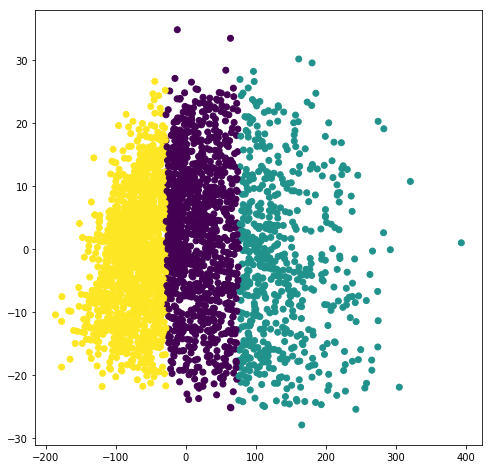

In [22]:
plt.figure(figsize=(8,8))
plt.scatter(X_pca[:,0], X_pca[:,1], c = prediction)
plt.show()

In [23]:
from sklearn.cluster import MeanShift, estimate_bandwidth

# Here we set the bandwidth. This function automatically derives a bandwidth
# number based on an inspection of the distances among points in the data.
bandwidth = estimate_bandwidth(X_pca, quantile=0.2, n_samples=500)

# Declare and fit the model.
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X_pca)

# Extract cluster assignments for each data point.
labels = ms.labels_

# Coordinates of the cluster centers.
cluster_centers = ms.cluster_centers_

# Count our clusters.
n_clusters_ = len(np.unique(labels))

print("Number of estimated clusters: {}".format(n_clusters_))

Number of estimated clusters: 3


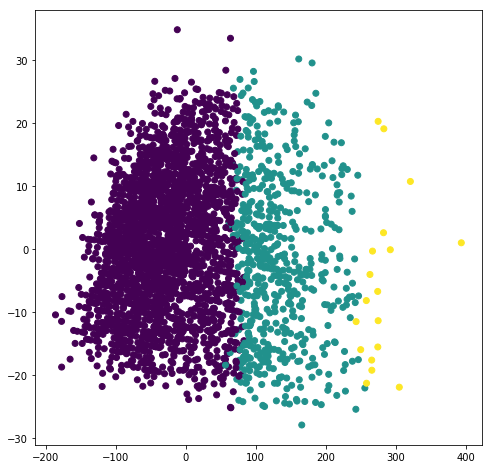

In [24]:
plt.figure(figsize=(8,8))
plt.scatter(X_pca[:,0], X_pca[:,1], c = labels)
plt.show()

In [25]:
#from sklearn.cluster import SpectralClustering

#n_clusters = 3

# Declare and fit the model.
#sc = SpectralClustering(n_clusters=n_clusters)
#sc.fit(x_train)

#Predicted clusters.
#predict = sc.fit_predict(x_train)

# Graph results
#plt.figure(figsize=(8,8))
#plt.scatter(x_train[:,0], x_train[:,1], c = predict)
#plt.show()

In [26]:
# Figure out whats slowing down Spectral Clusturing
# Decide if PCAs are necessary and or valuable in clustering algorithms